In [1]:
library(lme4)
library(sjPlot)
library(Hmisc)

library(gridExtra)
library(ggplot2)

# custom style for tab models
css = list(
    css.thead = 'border-top: double; text-align:center; font-style:normal; font-weight:bold; padding:0.1cm;',
    css.tdata = 'padding:0.05cm; padding-left:0.2cm; padding-right:0.2cm; text-align:left; vertical-align:top;',
    css.depvarhead = 'text-align:center; border-bottom:1px solid; font-style:italic; font-weight:bold',
    css.summary = 'padding-top:0.05cm; padding-bottom:0.05cm;'
  )

Loading required package: Matrix

#refugeeswelcome

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units




# Read Data

In [2]:
wtdata <- read.csv("data/dataset_A_linked.csv")

# filter the relevant analysis period
wtdata = wtdata[wtdata$is_analysis_period,]

# Demographics and statistics

In [3]:
# number of results
cat(paste('Number of results:', nrow(wtdata), '\n'))

# number of search pages
cat(paste('Number of search pages:', nrow(wtdata[!duplicated(wtdata['search_page']),]), '\n'))

# remove the duplicates (as one participant can be measured multiple times)
wtparticipants = wtdata[!duplicated(wtdata['participant']), 
                        c('participant', 'age_val', 'education_val', 'political_alignment_val', 
                          'is_west_germany_val', 'is_female_val', 'is_diverse_val')]

# number of participants
cat(paste('Number of results:', nrow(wtparticipants), '\n'))


Number of results: 2754 
Number of search pages: 611 
Number of results: 194 


In [4]:
# generate the descriptive statistics for each variable
for (col in c('is_female_val',
              'is_diverse_val',
              'is_west_germany_val', 
              'education_val',
              'age_val',   
              'political_alignment_val'
              )){
    cat(paste0('\n\n####### ',col,' ######\n'))
    print(describe(wtparticipants[[col]]))
    cat(paste0('#######',col,' ######\n'))
}



####### is_female_val ######
wtparticipants[[col]] 
       n  missing distinct 
     193        1        2 
                      
Value      FALSE  TRUE
Frequency    103    90
Proportion 0.534 0.466
#######is_female_val ######


####### is_diverse_val ######
wtparticipants[[col]] 
       n  missing distinct 
     193        1        2 
                      
Value      FALSE  TRUE
Frequency    192     1
Proportion 0.995 0.005
#######is_diverse_val ######


####### is_west_germany_val ######
wtparticipants[[col]] 
       n  missing distinct     Info     Mean      Gmd 
     193        1        2    0.502    1.788   0.3364 
                      
Value          1     2
Frequency     41   152
Proportion 0.212 0.788
#######is_west_germany_val ######


####### education_val ######
wtparticipants[[col]] 
       n  missing distinct     Info     Mean      Gmd 
     193        1        3    0.799    2.425   0.7097 
                            
Value          1     2     3
Frequency     23    

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing non-finite values (stat_bin).”


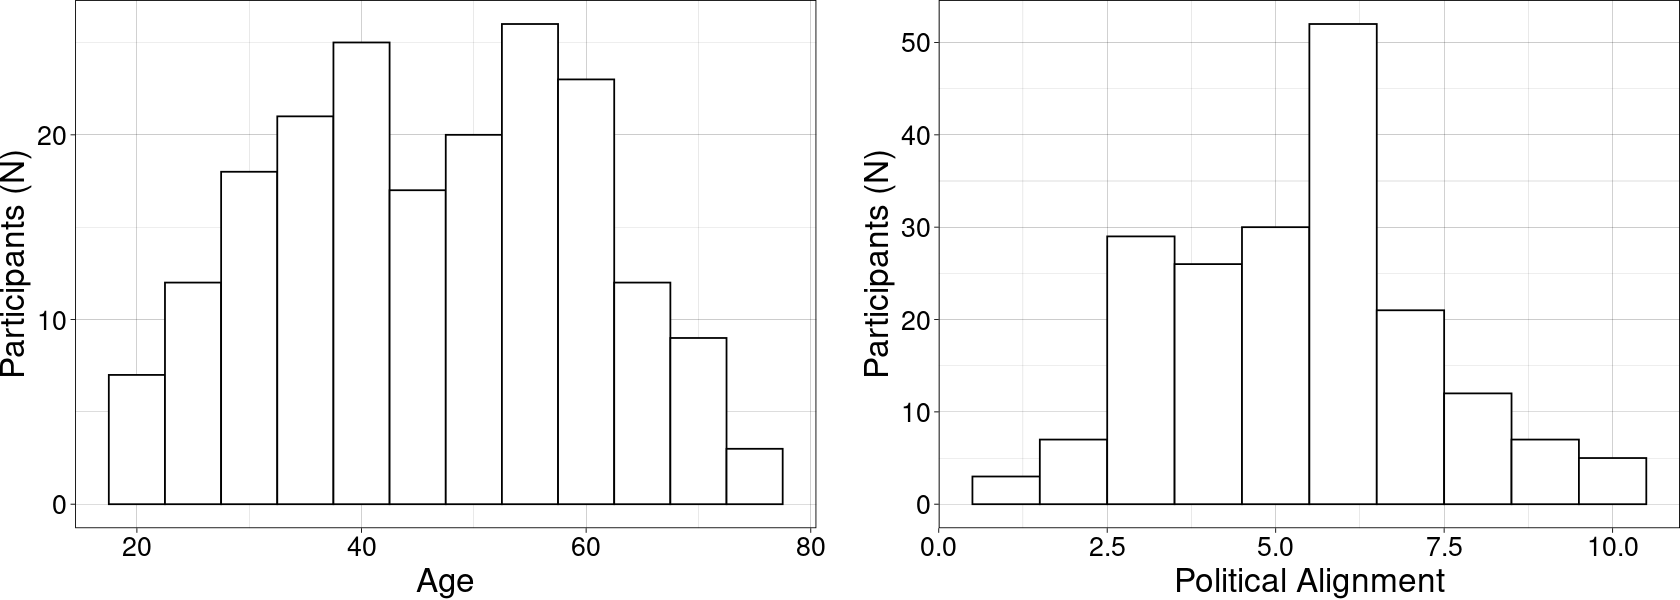

In [5]:
# Distribution of age
age_plot = ggplot(wtparticipants, aes(x=age_val)) + 
  geom_histogram(binwidth=5, colour="black", fill="white") +
   theme_linedraw()  + theme(text = element_text(size = 20))  +
   xlab("Age") + ylab("Participants (N)") +
   theme(plot.margin = unit(c(0,0.5,0,0), "cm"))

# Distribution of the political alignment
pol_align_plot = ggplot(wtparticipants, aes(x=political_alignment_val)) + 
  geom_histogram(binwidth=1, colour="black", fill="white") +
   theme_linedraw()  + theme(text = element_text(size = 20)) +
  xlab("Political Alignment") + ylab("Participants (N)") + 
   theme(plot.margin = unit(c(0,0,0,0.5), "cm"))

# display plost side to side
options(repr.plot.width=14, repr.plot.height=5)
grid.arrange(age_plot, pol_align_plot, ncol = 2) 

# Scale and center variables

In [6]:
# scale and center the election periods
wtdata$is_before_elections <- scale(wtdata$election_period_cat == 'A', scale=T)
wtdata$is_during_elections <- scale(wtdata$election_period_cat == 'B', scale=T)
wtdata$is_after_elections <- scale(wtdata$election_period_cat == 'C', scale=T)

# scaling the rest of the variables
wtdata$rank <- scale(wtdata$rank, scale=T)
# invert this value so that the odds ratio, so it the scaled scores
# match the intuition, i.e. the 1st result should have a higher (positive)
# value. The odds ratio are then easier to interpret.
wtdata$inv_rank <- -1 * wtdata$rank

# scale and center the representativeness
wtdata$news_representativeness <- scale(wtdata$news_representativeness, scale=T)

# scale and center engagement variables
wtdata$engagement_TI_B1 <- scale(wtdata$engagement_TI_B1, scale=T)
wtdata$engagement_TI_C1 <- scale(wtdata$engagement_TI_C1, scale=T)
wtdata$engagement_TI_D1 <- scale(wtdata$engagement_TI_D1, scale=T)

# convert to factors the within subjects
wtdata$search_page <- as.factor(wtdata$search_page)
wtdata$participant <- as.factor(wtdata$participant)
wtdata$coredomain <- as.factor(wtdata$coredomain)

# Main test (fitting engagement as a proportion)

## Dataset B1: previous engagement

In [7]:
# time independent
ti_model_B1 <- glmer(is_selected_result ~ 

                              # main factors
                              engagement_TI_B1
                            * inv_rank
                            * news_representativeness 

                            # control for demographics
                            + is_female
                            + is_diverse
                            + is_west_germany
                            + age
                            + education
                            + political_alignment

                            # control for election day
                            + is_during_elections
                            + is_after_elections

                            # within subject controls
                            + (1|search_page)
                            + (1|coredomain)
                            + (1|participant)

                            , data=wtdata, family=binomial)

tab_model(ti_model_B1, wrap.labels = F, CSS = css, file = "statistical_tests/ti_model_B1.html")

boundary (singular) fit: see help('isSingular')



## Dataset C1: Google associated previous engagement

In [8]:
# time independent
ti_model_C1 <- glmer(is_selected_result ~ 

                              # main factors
                              engagement_TI_C1
                            * inv_rank
                            * news_representativeness 

                            # control for demographics
                            + is_female
                            + is_diverse
                            + is_west_germany
                            + age
                            + education
                            + political_alignment

                            # control for election day
                            + is_during_elections
                            + is_after_elections

                            # within subject controls
                            + (1|search_page)
                            + (1|coredomain)
                            + (1|participant)

                            , data=wtdata, family=binomial)

tab_model(ti_model_C1, wrap.labels = F, CSS = css, file = "statistical_tests/ti_model_C1.html")

boundary (singular) fit: see help('isSingular')



## Dataset D1: non Google associated previous engagement

In [9]:
# time independent
ti_model_D1 <- glmer(is_selected_result ~ 

                              # main factors
                              engagement_TI_D1
                            * inv_rank
                            * news_representativeness 

                            # control for demographics
                            + is_female
                            + is_diverse
                            + is_west_germany
                            + age
                            + education
                            + political_alignment

                            # control for election day
                            + is_during_elections
                            + is_after_elections

                            # within subject controls
                            + (1|search_page)
                            + (1|coredomain)
                            + (1|participant)

                            , data=wtdata, family=binomial)

tab_model(ti_model_D1, wrap.labels = F, CSS = css, file = "statistical_tests/ti_model_D1.html")

boundary (singular) fit: see help('isSingular')

